In [1]:
!pip install catboost
!pip install anchor-exp
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.3/427.3 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 19.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for anchor-exp: filename=anchor_exp-0.0.2.0-py3-none-any.whl size=433502 sha256=72087435be5479320b01e6cf9ad71044cb0201e0ddd7dc5fe8ca89f39b49b52f
  Stored in directory: /root/.cache/pip/wheels/02/f9/94/c51254cde228ec1397f5c2dafb60bacab62c53159f000857fe
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=e6d6a4a9b231d48c94fba997291eaf2fc9387608ab6b323e3613b0997bbdfe5a
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built anchor-exp lime


In [111]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, precision_recall_curve, auc, confusion_matrix
)
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import seaborn as sns
from anchor import anchor_tabular

In [112]:
# Importing shap library
import shap
shap.initjs()

In [113]:
#To display all the columns and rows
pd.set_option('display.max_columns', 1000);
pd.set_option('display.max_rows', 1000);
pd.set_option('display.width', 1000);
#To ignore warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
#To supress scientific notations
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [114]:
#Loading the necessary files
common_lasso_dataset = pd.read_csv("/content/drive/MyDrive/ColabNotebooks/Rare_Diseases_Research/Data/common_lasso_dataset.csv")
combo_lasso_dataset = pd.read_csv("/content/drive/MyDrive/ColabNotebooks/Rare_Diseases_Research/Data/combo_lasso_dataset.csv")
rare_lasso_dataset = pd.read_csv("/content/drive/MyDrive/ColabNotebooks/Rare_Diseases_Research/Data/rare_lasso_dataset.csv")
common_skin_lasso_dataset = pd.read_csv("/content/drive/MyDrive/ColabNotebooks/Rare_Diseases_Research/Data/common_skin_lasso_dataset.csv")
case_2_dataset = pd.read_csv("/content/drive/MyDrive/ColabNotebooks/Rare_Diseases_Research/Data/case_2_dataset.csv")
eda_disorders = pd.read_csv("/content/drive/MyDrive/ColabNotebooks/Rare_Diseases_Research/Data/eda_disorders.csv")

In [115]:
#Categorical map for ANCHORs
cat_map={0:['Zero','Male','Female'],
         3:['Zero','OBSERVATION ADMIT', 'EW EMER.', 'EU OBSERVATION', 'URGENT', 'DIRECT OBSERVATION', 'SURGICAL SAME DAY ADMISSION', 'DIRECT EMER.',
            'ELECTIVE', 'AMBULATORY OBSERVATION'],
         4:['Zero','EMERGENCY ROOM', 'PHYSICIAN REFERRAL', 'TRANSFER FROM HOSPITAL', 'WALK-IN/SELF REFERRAL', 'CLINIC REFERRAL',
            'INTERNAL TRANSFER TO OR FROM PSYCH', 'TRANSFER FROM SKILLED NURSING FACILITY', 'AMBULATORY SURGERY TRANSFER',
            'PROCEDURE SITE', 'PACU', 'INFORMATION NOT AVAILABLE'],
         5:['Zero','HOME', 'HOME HEALTH CARE', 'SKILLED NURSING FACILITY', 'DIED', 'REHAB', 'HOSPICE', 'CHRONIC/LONG TERM ACUTE CARE',
            'AGAINST ADVICE', 'ACUTE HOSPITAL', 'PSYCH FACILITY', 'OTHER FACILITY', 'ASSISTED LIVING', 'HEALTHCARE FACILITY', 'INFORMATION NOT AVAILABLE'],
         6:['Zero','Medicare','Medicaid','Other'],
         7:['Zero','English','Other'],
         8:['Zero','MARRIED', 'SINGLE', 'DIVORCED', 'WIDOWED', 'INFORMATION NOT AVAILABLE'],
         9:['Zero','WHITE', 'BLACK', 'ASIAN', 'LATINOS', 'OTHERS', 'UNKNOWN'],
         14:['Zero','WINTER', 'SPRING', 'SUMMER', 'FALL']
         }

## Explaining CSD vs RSD

In [116]:
# Code for building the model just for CSD vs RSD dataset
# Separate features and target
X = common_skin_lasso_dataset.drop(columns=["target"])
y = common_skin_lasso_dataset["target"]

# Train-test split
X = X.replace(-99999, np.nan)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Save to new dataframes
X_train_common_skin_df = X_train.copy()
y_train_common_skin_df = y_train.copy()
X_test_common_skin_df = X_test.copy()
y_test_common_skin_df = y_test.copy()

# Train CatBoost
model3 = CatBoostClassifier(verbose=0, random_state=42)
model3.fit(X_train, y_train)

# Get predictions and probabilities
y_pred = model3.predict(X_test)
y_proba_1 = model3.predict_proba(X_test)[:, 1]  # Probabilities for class 1
y_proba_0 = model3.predict_proba(X_test)[:, 0]  # Probabilities for class 0

# Define feature names
feature_names_common_skin = X_train_common_skin_df.columns.tolist()

# Combine test set info into a single DataFrame
results_common_skin_df = X_test.copy()
results_common_skin_df["y_true"] = y_test.values
results_common_skin_df["y_pred"] = y_pred
results_common_skin_df["y_proba_1"] = y_proba_1
results_common_skin_df["y_proba_0"] = y_proba_0

# Define outcome category (TP, FP, TN, FN)
results_common_skin_df["pred_type"] = np.where(
    (results_common_skin_df["y_true"] == 1) & (results_common_skin_df["y_pred"] == 1), "TP",
    np.where((results_common_skin_df["y_true"] == 0) & (results_common_skin_df["y_pred"] == 1), "FP",
    np.where((results_common_skin_df["y_true"] == 0) & (results_common_skin_df["y_pred"] == 0), "TN", "FN"))
)

# Filter probabilities between 0.5 to 1.0
filtered_1 = results_common_skin_df[results_common_skin_df["y_proba_1"] >= 0.5]
filtered_0 = results_common_skin_df[results_common_skin_df["y_proba_0"] >= 0.5]

In [117]:
# Convert specified columns to integer so that record_key isn't different between the two datasets
results_common_skin_df[['anchor_age', 'anchor_year', 'gender']] = results_common_skin_df[['anchor_age', 'anchor_year', 'gender']].astype('Int64')
# Add record_key to each original results dataframe which will be used for identification
for df in [case_2_dataset, results_common_skin_df]:
    df['record_key'] = df[['bmi', 'anchor_age', 'anchor_year', 'gender', 'los']].astype(str).agg('-'.join, axis=1)

#Creating the new merged dataframe that can be used for interpretability analysis along with model classification results
#Select relevant columns from eda_disorders
eda_subset = eda_disorders[['subject_id', 'hadm_id', 'icd_code', 'Classification', 'long_title']]
#Merge with case_2_dataset
interpretability_df = pd.merge(case_2_dataset, eda_subset, on=['subject_id', 'hadm_id'], how='left')
#This interpretability_df can be combined and modified to be used with any dataset or subset for analysis.
#Select relevant columns from interpretability_df
interpret_subset = interpretability_df[['record_key', 'icd_code', 'Classification', 'long_title']]
#Merge with results_common_skin_df on record_key
results_common_skin_df_interpretable = pd.merge(results_common_skin_df, interpret_subset, on='record_key', how='left')

In [118]:
results_common_skin_df_interpretable.shape

(726, 109)

In [119]:
results_common_skin_df.shape

(726, 106)

In [120]:
# Check if there are any duplicate rows
has_duplicates = results_common_skin_df_interpretable.duplicated().any()
print("Any duplicates?", has_duplicates)

Any duplicates? False


In [122]:
results_common_skin_df['pred_type'].value_counts()

,count
pred_type,
TN,378
FN,199
TP,84
FP,65


In [121]:
results_common_skin_df_interpretable['pred_type'].value_counts()

,count
pred_type,
TN,378
FN,199
TP,84
FP,65


In [127]:
fp_icd_counts_df = (
    results_common_skin_df_interpretable[results_common_skin_df_interpretable['pred_type'] == 'FP']
    .groupby('icd_code')
    .size()
    .reset_index(name='count')
    .sort_values(by='count', ascending=False)
)

print(fp_icd_counts_df)


   icd_code  count
18      R21     22
8      L409      8
5      L259      5
2      L089      4
11     L509      3
15     L719      3
0      B353      2
16     L821      2
12     L570      2
7      L309      2
9      L500      2
1      B356      1
3     L2389      1
4      L239      1
6      L280      1
10     L508      1
13     L700      1
14     L709      1
17      L84      1


In [128]:
# Using SHAP to explain the model's predictions
%%time
explainer_shap_common_skin = shap.TreeExplainer(model3)
shap_values_common_skin = explainer_shap_common_skin.shap_values(X_test_common_skin_df)

CPU times: user 4.15 s, sys: 132 ms, total: 4.28 s
Wall time: 4.75 s


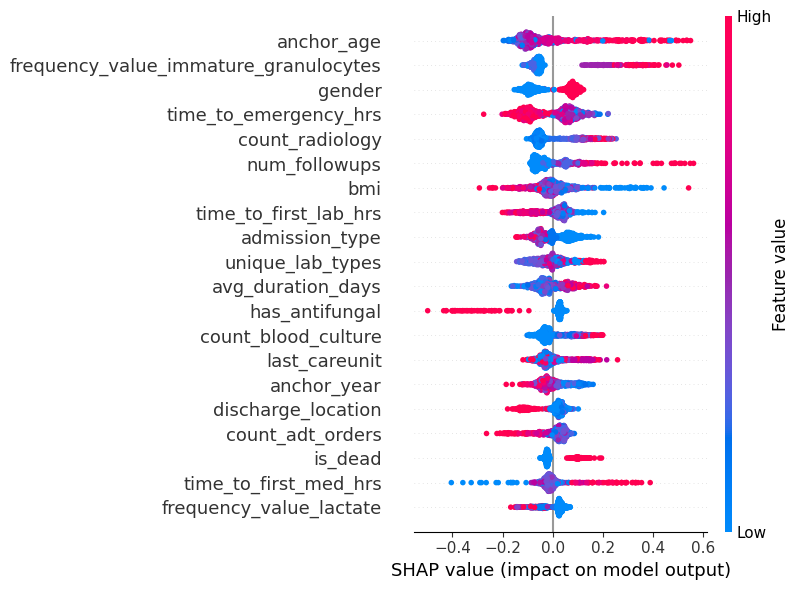

In [129]:
#SHAP Summary plot
shap.summary_plot(shap_values_common_skin, X_test_common_skin_df, plot_size=(8, 6), max_display=20)

In [155]:
# Find the positional index of the row with index
positional_index = X_test_common_skin_df.index.get_loc(911)
# Retrieve the feature values and SHAP values for the row with index
instance = X_test_common_skin_df.loc[911]
shap_values_for_instance = shap_values_common_skin[positional_index, :]
shap.initjs()
# Generate the SHAP force plot
shap.force_plot(explainer_shap_common_skin.expected_value, shap_values_for_instance, instance)

In [156]:
#Creating an anchor explainer object by providing feature names, categorical mapping, output values and training data
anchor_explainer_common_skin = anchor_tabular.AnchorTabularExplainer(['Common Skin Disease','Rare Skin Disease'],
                                                                feature_names_common_skin,X_train_common_skin_df.values,categorical_names=cat_map)

In [157]:
#Generating explanation of a particular record from the test data
exp_instance = anchor_explainer_common_skin.explain_instance(X_test_common_skin_df.loc[911].to_numpy(), model3.predict, threshold=0.95)
#Generating the ANCHORs in human readable format
print('IF %s THEN %s' % (' AND '.join(exp_instance.names()),
                         anchor_explainer_common_skin.class_names[model3.predict(X_test_common_skin_df.loc[911].to_numpy().reshape(1, -1))[0]]))
print('Precision: %.2f' % exp_instance.precision())
print('Coverage: %.2f' % exp_instance.coverage())

IF anchor_age <= 60.00 AND count_cardiology <= 0.00 AND bmi > 27.80 AND num_followups <= 1.00 AND first_careunit <= 3.00 AND count_nutrition > 2.00 AND time_to_first_abnormal_lab_hrs > 11.78 THEN Common Skin Disease
Precision: 0.96
Coverage: 0.01


In [178]:
results_common_skin_df[results_common_skin_df['record_key']=='29.2-49-2190-1-44.40625']

,gender,anchor_age,anchor_year,admission_type,admission_location,discharge_location,insurance,language,marital_status,race,hospital_expire_flag,num_followups,is_dead,los,admission_season,time_to_emergency_hrs,admit_month,is_night_admit,is_weekend_admit,no_of_unique_procedures,count_icu_critical_procedures,bmi,no_of_transfers,no_of_distinct_careunits,no_of_ed_transfers,first_careunit,last_careunit,no_of_icu_stays,count_adt_orders,count_blood_bank,count_cardiology,count_consults,count_critical_care,count_general_care,count_hemodialysis,count_iv_therapy,count_neurology,count_nutrition,count_ob,count_radiology,count_respiratory,count_tpn,count_abscess,count_blood_culture,count_sputum,count_stool,count_swab,count_tissue,count_urine,total_microbiologyevents,positive_cultures,resistant_tests,route_eyes,route_iv,route_oral,route_others,route_skin,unique_medications,prn_med_count,eyes_prescribed_route,avg_duration_days,max_duration_days,has_insulin,has_heparin,has_aspirin,has_ibuprofen,has_fluids,has_antibiotics,has_analgesics,has_antifungal,has_steroid,has_topical,has_immunosuppressant,has_antihistamine,has_moisturizer,has_antiviral,has_antidepressant,has_pain_management,has_diuretics,has_vaccine,has_ace_inhibitor,has_statins,time_to_first_med_hrs,diff_in_medicines,polypharmacy,unique_lab_types,frequency_value_albumin,frequency_value_immature_granulocytes,frequency_value_lactate,frequency_value_specific_gravity,time_to_first_lab_hrs,time_to_first_abnormal_lab_hrs,anchor_year_start,anchor_year_end,has_abnormal_electrolyte_fluid,has_abnormal_glucose_metabolic,has_abnormal_hematologic,has_abnormal_metabolic_acidbase,has_abnormal_rbc_indices,has_abnormal_renal,y_true,y_pred,y_proba_1,y_proba_0,pred_type,record_key
911,1,49,2190,2.000,1.000,7.000,3.000,1.000,2.000,1.000,0.000,1.000,0.000,44.406,3.000,-6.217,7.000,1.000,0.000,7.000,6.000,29.200,9.000,7.000,1.000,3.000,7.000,2.000,19.000,3.000,0.000,10.000,0.000,80.000,0.000,75.000,1.000,34.000,0.000,66.000,17.000,17.000,0.000,12.000,16.000,13.000,0.000,0.000,28.000,77.000,36.000,10.000,2.000,167.000,133.000,36.000,11.000,99.000,63.000,2.000,4.331,44.375,1.000,1.000,1.000,0.000,1.000,1.000,1.000,0.000,0.000,1.000,0.000,1.000,1.000,1.000,1.000,1.000,0.000,1.000,0.000,1.000,4.933,17.000,1.000,146.000,10.000,2.000,18.000,9.000,16.183,16.183,2011.000,2013.000,1.000,0.000,1.000,1.000,1.000,1.000,1,0,0.393,0.607,FN,29.2-49-2190-1-44.40625


In [177]:
results_common_skin_df_interpretable[results_common_skin_df_interpretable['record_key']=='29.2-49-2190-1-44.40625']

,gender,anchor_age,anchor_year,admission_type,admission_location,discharge_location,insurance,language,marital_status,race,hospital_expire_flag,num_followups,is_dead,los,admission_season,time_to_emergency_hrs,admit_month,is_night_admit,is_weekend_admit,no_of_unique_procedures,count_icu_critical_procedures,bmi,no_of_transfers,no_of_distinct_careunits,no_of_ed_transfers,first_careunit,last_careunit,no_of_icu_stays,count_adt_orders,count_blood_bank,count_cardiology,count_consults,count_critical_care,count_general_care,count_hemodialysis,count_iv_therapy,count_neurology,count_nutrition,count_ob,count_radiology,count_respiratory,count_tpn,count_abscess,count_blood_culture,count_sputum,count_stool,count_swab,count_tissue,count_urine,total_microbiologyevents,positive_cultures,resistant_tests,route_eyes,route_iv,route_oral,route_others,route_skin,unique_medications,prn_med_count,eyes_prescribed_route,avg_duration_days,max_duration_days,has_insulin,has_heparin,has_aspirin,has_ibuprofen,has_fluids,has_antibiotics,has_analgesics,has_antifungal,has_steroid,has_topical,has_immunosuppressant,has_antihistamine,has_moisturizer,has_antiviral,has_antidepressant,has_pain_management,has_diuretics,has_vaccine,has_ace_inhibitor,has_statins,time_to_first_med_hrs,diff_in_medicines,polypharmacy,unique_lab_types,frequency_value_albumin,frequency_value_immature_granulocytes,frequency_value_lactate,frequency_value_specific_gravity,time_to_first_lab_hrs,time_to_first_abnormal_lab_hrs,anchor_year_start,anchor_year_end,has_abnormal_electrolyte_fluid,has_abnormal_glucose_metabolic,has_abnormal_hematologic,has_abnormal_metabolic_acidbase,has_abnormal_rbc_indices,has_abnormal_renal,y_true,y_pred,y_proba_1,y_proba_0,pred_type,record_key,icd_code,Classification,long_title
2,1,49,2190,2.000,1.000,7.000,3.000,1.000,2.000,1.000,0.000,1.000,0.000,44.406,3.000,-6.217,7.000,1.000,0.000,7.000,6.000,29.200,9.000,7.000,1.000,3.000,7.000,2.000,19.000,3.000,0.000,10.000,0.000,80.000,0.000,75.000,1.000,34.000,0.000,66.000,17.000,17.000,0.000,12.000,16.000,13.000,0.000,0.000,28.000,77.000,36.000,10.000,2.000,167.000,133.000,36.000,11.000,99.000,63.000,2.000,4.331,44.375,1.000,1.000,1.000,0.000,1.000,1.000,1.000,0.000,0.000,1.000,0.000,1.000,1.000,1.000,1.000,1.000,0.000,1.000,0.000,1.000,4.933,17.000,1.000,146.000,10.000,2.000,18.000,9.000,16.183,16.183,2011.000,2013.000,1.000,0.000,1.000,1.000,1.000,1.000,1,0,0.393,0.607,FN,29.2-49-2190-1-44.40625,G901,"rare_genetic_diseases, rare_neurological_disea...",Familial dysautonomia [Riley-Day]


In [132]:
results_common_skin_df_interpretable.head()

,gender,anchor_age,anchor_year,admission_type,admission_location,discharge_location,insurance,language,marital_status,race,hospital_expire_flag,num_followups,is_dead,los,admission_season,time_to_emergency_hrs,admit_month,is_night_admit,is_weekend_admit,no_of_unique_procedures,count_icu_critical_procedures,bmi,no_of_transfers,no_of_distinct_careunits,no_of_ed_transfers,first_careunit,last_careunit,no_of_icu_stays,count_adt_orders,count_blood_bank,count_cardiology,count_consults,count_critical_care,count_general_care,count_hemodialysis,count_iv_therapy,count_neurology,count_nutrition,count_ob,count_radiology,count_respiratory,count_tpn,count_abscess,count_blood_culture,count_sputum,count_stool,count_swab,count_tissue,count_urine,total_microbiologyevents,positive_cultures,resistant_tests,route_eyes,route_iv,route_oral,route_others,route_skin,unique_medications,prn_med_count,eyes_prescribed_route,avg_duration_days,max_duration_days,has_insulin,has_heparin,has_aspirin,has_ibuprofen,has_fluids,has_antibiotics,has_analgesics,has_antifungal,has_steroid,has_topical,has_immunosuppressant,has_antihistamine,has_moisturizer,has_antiviral,has_antidepressant,has_pain_management,has_diuretics,has_vaccine,has_ace_inhibitor,has_statins,time_to_first_med_hrs,diff_in_medicines,polypharmacy,unique_lab_types,frequency_value_albumin,frequency_value_immature_granulocytes,frequency_value_lactate,frequency_value_specific_gravity,time_to_first_lab_hrs,time_to_first_abnormal_lab_hrs,anchor_year_start,anchor_year_end,has_abnormal_electrolyte_fluid,has_abnormal_glucose_metabolic,has_abnormal_hematologic,has_abnormal_metabolic_acidbase,has_abnormal_rbc_indices,has_abnormal_renal,y_true,y_pred,y_proba_1,y_proba_0,pred_type,record_key,icd_code,Classification,long_title
0,1,67,2171,1.000,4.000,4.000,1.000,1.000,1.000,1.000,1.000,0.000,1.000,26.796,4.000,-5.133,9.000,0.000,0.000,16.000,11.000,23.800,5.000,5.000,1.000,5.000,14.000,1.000,7.000,5.000,9.000,8.000,4.000,115.000,3.000,48.000,4.000,22.000,0.000,69.000,55.000,0.000,0.000,12.000,12.000,1.000,0.000,0.000,4.000,60.000,5.000,0.000,2.000,175.000,78.000,27.000,10.000,81.000,41.000,2.000,3.382,26.042,1.000,1.000,1.000,0.000,1.000,1.000,1.000,0.000,1.000,1.000,0.000,1.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,1.000,2.850,15.000,1.000,140.000,1.000,6.000,71.000,4.000,4.183,15.100,2017.000,2019.000,0.000,0.000,1.000,1.000,1.000,1.000,0,1,0.815,0.185,FP,23.8-67-2171-1-26.79583333333333,R21,common_skin_diseases,Rash and other nonspecific skin eruption
1,2,84,2185,3.000,1.000,14.000,1.000,1.000,4.000,1.000,0.000,6.000,0.000,0.953,2.000,-2.883,3.000,0.000,0.000,0.000,0.000,24.600,0.000,2.000,1.000,13.000,13.000,0.000,1.000,0.000,0.000,0.000,0.000,4.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2011.000,2013.000,0.000,0.000,0.000,0.000,0.000,0.000,0,0,0.345,0.655,TN,24.6-84-2185-2-0.9527777777777776,L570,common_skin_diseases,Actinic keratosis
2,1,49,2190,2.000,1.000,7.000,3.000,1.000,2.000,1.000,0.000,1.000,0.000,44.406,3.000,-6.217,7.000,1.000,0.000,7.000,6.000,29.200,9.000,7.000,1.000,3.000,7.000,2.000,19.000,3.000,0.000,10.000,0.000,80.000,0.000,75.000,1.000,34.000,0.000,66.000,17.000,17.000,0.000,12.000,16.000,13.000,0.000,0.000,28.000,77.000,36.000,10.000,2.000,167.000,133.000,36.000,11.000,99.000,63.000,2.000,4.331,44.375,1.000,1.000,1.000,0.000,1.000,1.000,1.000,0.000,0.000,1.000,0.000,1.000,1.000,1.000,1.000,1.000,0.000,1.000,0.000,1.000,4.933,17.000,1.000,146.000,10.000,2.000,18.000,9.000,16.183,16.183,2011.000,2013.000,1.000,0.000,1.000,1.000,1.000,1.000,1,0,0.393,0.607,FN,29.2-49-2190-1-44.40625,G901,"rare_genetic_diseases, rare_neurological_disea...",Familial dysautonomia [Riley-Day]
3,2,48,2170,2.000

Creating separate dataframes for separate prediction types

In [171]:
# Create separate DataFrames for each prediction type
fp_df = results_common_skin_df_interpretable[results_common_skin_df_interpretable["pred_type"] == "FP"].copy()
tp_df = results_common_skin_df_interpretable[results_common_skin_df_interpretable["pred_type"] == "TP"].copy()
fn_df = results_common_skin_df_interpretable[results_common_skin_df_interpretable["pred_type"] == "FN"].copy()
tn_df = results_common_skin_df_interpretable[results_common_skin_df_interpretable["pred_type"] == "TN"].copy()

In [181]:
# Columns to drop
non_feature_cols = ["y_true", "y_pred", "y_proba_1", "y_proba_0", "pred_type","record_key", "icd_code", "Classification", "long_title"]

# Drop non-feature columns
fp_df_cl = fp_df.drop(columns=non_feature_cols, errors='ignore')
tp_df_cl = tp_df.drop(columns=non_feature_cols, errors='ignore')
fn_df_cl = fn_df.drop(columns=non_feature_cols, errors='ignore')
tn_df_cl = tn_df.drop(columns=non_feature_cols, errors='ignore')

In [182]:
# Using SHAP to explain the model's predictions
%%time
explainer_shap_common_skin = shap.TreeExplainer(model3)
shap_values_common_skin_fp = explainer_shap_common_skin.shap_values(fp_df_cl)

CPU times: user 5.59 s, sys: 138 ms, total: 5.73 s
Wall time: 11.6 s


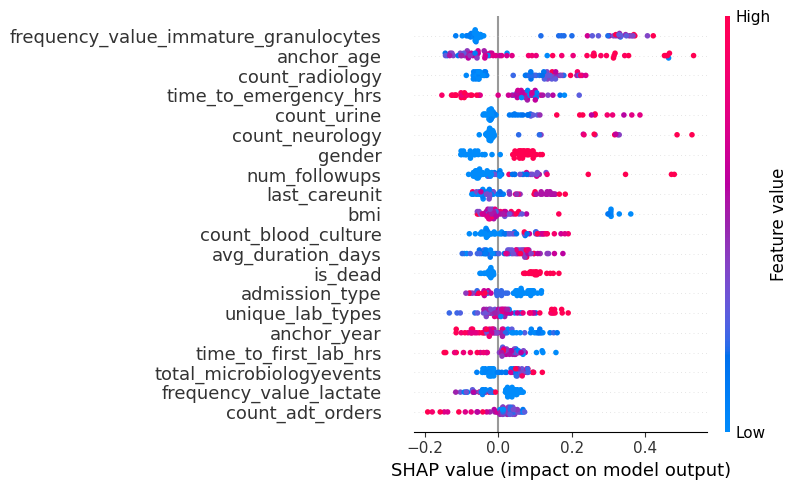

In [197]:
#SHAP Summary plot
shap.summary_plot(shap_values_common_skin_fp, fp_df_cl, plot_size=(8, 5), max_display=20)

In [184]:
# Using SHAP to explain the model's predictions
%%time
explainer_shap_common_skin = shap.TreeExplainer(model3)
shap_values_common_skin_fn = explainer_shap_common_skin.shap_values(fn_df_cl)

CPU times: user 4.23 s, sys: 79.4 ms, total: 4.31 s
Wall time: 2.77 s


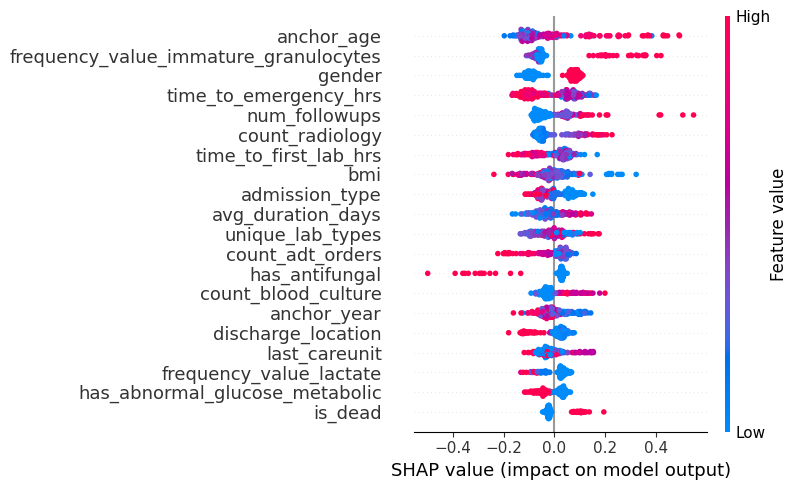

In [194]:
#SHAP Summary plot
shap.summary_plot(shap_values_common_skin_fn, fn_df_cl, plot_size=(8, 5), max_display=20)

In [186]:
# Using SHAP to explain the model's predictions
%%time
explainer_shap_common_skin = shap.TreeExplainer(model3)
shap_values_common_skin_tp = explainer_shap_common_skin.shap_values(tp_df_cl)

CPU times: user 4.12 s, sys: 148 ms, total: 4.27 s
Wall time: 5.55 s


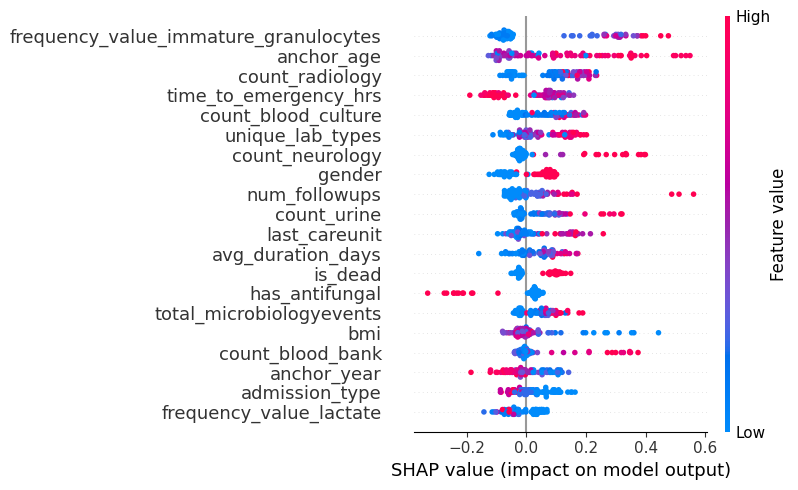

In [195]:
#SHAP Summary plot
shap.summary_plot(shap_values_common_skin_tp, tp_df_cl, plot_size=(8, 5), max_display=20)

In [188]:
# Using SHAP to explain the model's predictions
%%time
explainer_shap_common_skin = shap.TreeExplainer(model3)
shap_values_common_skin_tn = explainer_shap_common_skin.shap_values(tn_df_cl)

CPU times: user 4.04 s, sys: 93.5 ms, total: 4.13 s
Wall time: 6.22 s


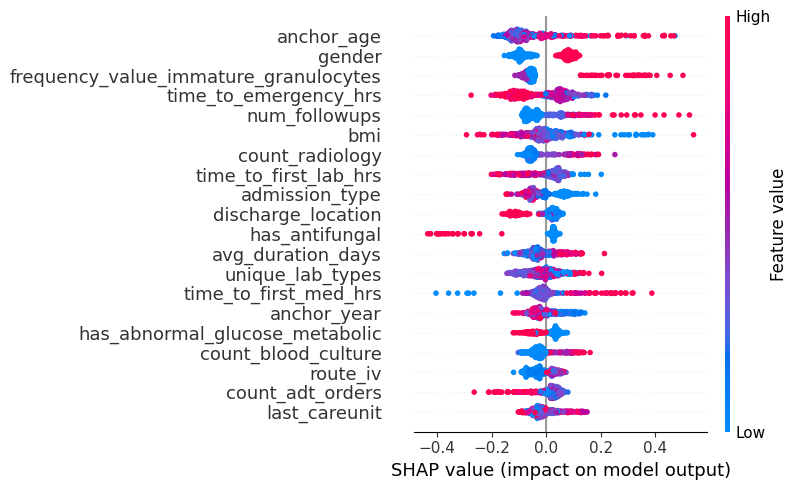

In [196]:
#SHAP Summary plot
shap.summary_plot(shap_values_common_skin_tn, tn_df_cl, plot_size=(8, 5), max_display=20)

Now that you have your merged dataframe talk about each prediction type separately. If required you can also go deeper into each prediction type by confidence level.

Question: What all must you check in each prediction type?

1. A SHAP graph vs the original test dataset
2. Analyse by age, race, and gender (or the imp predictors in each case)
3. Check the icd codes are the errors biologically resonable?
4. Analyse FP and FN using ANCHORs, get 3-5 ANCHOR rules that are even able to explain 10-20% of misclassifications.  



## Improving CSD vs RSD - didn't help

In [15]:
merged_labs = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/Rare_Diseases_Research/Data/merged_labs.csv')

/tmp/ipython-input-4243505213.py:1: DtypeWarning: Columns (7,16) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_labs = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/Rare_Diseases_Research/Data/merged_labs.csv')


In [16]:
#Filling up as this might be used later for other classification or regression tasks
merged_labs['time_to_diagnosis'] = merged_labs['time_to_diagnosis'].fillna(0)
merged_labs['days_to_next_admission'] = merged_labs['days_to_next_admission'].fillna(-1)

In [17]:
merged_labs.shape

(56917, 2389)

In [18]:
merged_labs.head()

,subject_id,hadm_id,procedures_applied,icd_code,long_title,seq_num,Classification,included,class,gender,anchor_age,anchor_year,anchor_year_group,dod,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag,is_first_admission,num_followups,future_rare_skin,icd_code_list,next_admittime,days_to_next_admission,time_to_diagnosis,is_dead,los,admission_season,time_to_emergency_hrs,admit_month,is_night_admit,is_weekend_admit,total_no_of_procedures,no_of_unique_procedures,count_icu_critical_procedures,bmi,bmi_chartdate,no_of_transfers,no_of_distinct_careunits,no_of_ed_transfers,first_careunit,careunit_transfer_sequence,last_careunit,no_of_icu_stays,count_adt_orders,count_blood_bank,count_cardiology,count_consults,count_critical_care,count_general_care,count_hemodialysis,count_iv_therapy,count_lab,count_medications,count_neurology,count_nutrition,count_ob,count_radiology,count_respiratory,count_tpn,count_abscess,count_blood_culture,count_sputum,count_stool,count_swab,count_tissue,count_urine,total_microbiologyevents,positive_cultures,negative_cultures,susceptible_tests,resistant_tests,organisms_found,first_culture_time,spec_types,route_eyes,route_iv,route_oral,route_others,route_skin,total_medications,unique_medications,medications_given,prn_med_count,first_med_time,total_med_duration,avg_med_duration,max_med_duration,num_prescriptions_drugs,num_unique_prescriptions_drugs,drug_list,eyes_prescribed_route,iv_prescribed_route,oral_prescribed_route,others_prescribed_route,skin_prescribed_route,avg_dose_val,max_dose_val,avg_duration_days,max_duration_days,has_insulin,has_heparin,has_aspirin,has_ibuprofen,has_fluids,has_antibiotics,has_analgesics,has_antifungal,has_steroid,has_topical,has_immunosuppressant,has_antihistamine,has_moisturizer,has_antiviral,has_antidepressant,has_pain_management,has_diuretics,has_vaccine,has_ace_inhibitor,has_statins,time_to_first_med_hrs,diff_in_medicines,polypharmacy,total_lab_tests,unique_lab_types,abnormal_lab_count,first_lab_time,first_abnormal_lab_time,first_value_%_hemoglobin_a1c,first_value_24_hr_calcium,first_value_24_hr_creatinine,first_value_24_hr_protein,first_value_25-oh_vitamin_d,first_value_arch-1,first_value_absolute_basophil_count,first_value_absolute_cd3_count,first_value_absolute_cd4_count,first_value_absolute_cd8_count,first_value_absolute_eosinophil_count,first_value_absolute_lymphocyte_count,first_value_absolute_monocyte_count,first_value_absolute_neutrophil_count,first_value_acetaminophen,first_value_alanine_aminotransferase_(alt),first_value_albumin,"first_value_albumin,_ascites","first_value_albumin,_body_fluid","first_value_albumin,_pleural","first_value_albumin,_urine","first_value_albumin/creatinine,_urine",first_value_alkaline_phosphatase,first_value_alpha-fetoprotein,first_value_alveolar-arterial_gradient,first_value_amikacin,first_value_ammonia,first_value_amylase,"first_value_amylase,_ascites","first_value_amylase,_body_fluid","first_value_amylase,_pleural","first_value_amylase,_urine","first_value_amylase/creatinine_ratio,_urine",first_value_anion_gap,first_value_anisocytosis,first_value_anti-dgp_(iga/igg),first_value_anti-thyroglobulin_antibodies,first_value_antithrombin,first_value_asparate_aminotransferase_(ast),first_value_atypical_lymphocytes,first_value_bacteria,first_value_bands,first_value_base_excess,first_value_basophilic_stippling,first_value_basophils,first_value_beta_hydroxybutyrate,first_value_beta-2_microglobulin,first_value_bicarbonate,"first_value_bicarbonate,_stool","first_value_bicarbonate,_urine","first_value_bilirubin,_direct","first_value_bilirubin,_indirect","first_value_bilirubin,_total","first_value_bilirubin,_total,_ascites","first_value_bilirubin,_total,_body_fluid","first_value_bilirubin,_total,_csf","first_value_bilirubin,_total,_pleural",first_value_blasts,first_value_blood_parasite_smear,first_value_broad_casts,first_value_c-reactive_protein,firs

In [19]:
csdvsrsd = merged_labs[merged_labs['class'].isin([1, 2])]

In [20]:
csdvsrsd.shape

(3695, 2389)

In [21]:
csdvsrsd['class'].value_counts()

,count
class,
2,2280
1,1415


In [23]:
csdvsrsd.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 3695 entries, 11 to 56900
Data columns (total 2389 columns):
 #     Column                                                  Non-Null Count  Dtype  
---    ------                                                  --------------  -----  
 0     subject_id                                              3695 non-null   int64  
 1     hadm_id                                                 3695 non-null   int64  
 2     procedures_applied                                      2024 non-null   object 
 3     icd_code                                                3695 non-null   object 
 4     long_title                                              3695 non-null   object 
 5     seq_num                                                 3695 non-null   int64  
 6     Classification                                          3695 non-null   object 
 7     included                                                3695 non-null   object 
 8     class            

In [24]:
missing_ratio = csdvsrsd.isnull().mean()   # fraction of missing values per column
missing_over_70 = missing_ratio[missing_ratio > 0.7].sort_values(ascending=False)
print(missing_over_70)

last_value_urea_nitrogen,_body_fluid   1.000
first_value_24_hr_calcium              1.000
last_value_urea_nitrogen,_ascites      1.000
last_value_bicarbonate,_stool          1.000
last_value_basophilic_stippling        1.000
                                        ... 
first_value_po2                        0.760
max_value_epithelial_cells             0.715
last_value_epithelial_cells            0.715
min_value_epithelial_cells             0.715
first_value_epithelial_cells           0.715
Length: 1483, dtype: float64


In [26]:
# Split by class
class1 = csdvsrsd[csdvsrsd['class'] == 1]
class2 = csdvsrsd[csdvsrsd['class'] == 2]

# Missing percentage for each class
missing_class1 = class1.isnull().mean().sort_values(ascending=False) * 100
missing_class2 = class2.isnull().mean().sort_values(ascending=False) * 100

missing_comparison = pd.DataFrame({
    'Class_1_Missing_%': class1.isnull().mean() * 100,
    'Class_2_Missing_%': class2.isnull().mean() * 100
}).sort_values(by=['Class_1_Missing_%', 'Class_2_Missing_%'], ascending=False)

                                  Class_1_Missing_%  Class_2_Missing_%
first_value_24_hr_calcium                   100.000            100.000
first_value_anisocytosis                    100.000            100.000
first_value_bacteria                        100.000            100.000
first_value_basophilic_stippling            100.000            100.000
first_value_bicarbonate,_stool              100.000            100.000
...                                             ...                ...
polypharmacy                                  0.000              0.000
total_lab_tests                               0.000              0.000
unique_lab_types                              0.000              0.000
abnormal_lab_count                            0.000              0.000
phenotype_flags                               0.000              0.000

[2389 rows x 2 columns]


In [28]:
missing_comparison

,Class_1_Missing_%,Class_2_Missing_%
first_value_24_hr_calcium,100.000,100.000
first_value_anisocytosis,100.000,100.000
first_value_bacteria,100.000,100.000
first_value_basophilic_stippling,100.000,100.000
"first_value_bicarbonate,_stool",100.000,100.000
...,...,...
polypharmacy,0.000,0.000
total_lab_tests,0.000,0.000
unique_lab_types,0.000,0.000
abnormal_lab_count,0.000,0.000


In [34]:
#Removing columns with over 80% data missing
csdvsrsd = csdvsrsd.loc[:, csdvsrsd.isnull().mean() < 0.8]

In [35]:
csdvsrsd.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 3695 entries, 11 to 56900
Data columns (total 935 columns):
 #    Column                                       Non-Null Count  Dtype  
---   ------                                       --------------  -----  
 0    subject_id                                   3695 non-null   int64  
 1    hadm_id                                      3695 non-null   int64  
 2    procedures_applied                           2024 non-null   object 
 3    icd_code                                     3695 non-null   object 
 4    long_title                                   3695 non-null   object 
 5    seq_num                                      3695 non-null   int64  
 6    Classification                               3695 non-null   object 
 7    included                                     3695 non-null   object 
 8    class                                        3695 non-null   int64  
 9    gender                                       3695 non-null   obj

In [39]:
# Create a copy to avoid modifying the original directly
csdvsrsd_copy = csdvsrsd.copy()

# Ensure datetime columns are in correct format
csdvsrsd_copy['first_lab_time'] = pd.to_datetime(csdvsrsd_copy['first_lab_time'], errors='coerce')
csdvsrsd_copy['first_abnormal_lab_time'] = pd.to_datetime(csdvsrsd_copy['first_abnormal_lab_time'], errors='coerce')
csdvsrsd_copy['admittime'] = pd.to_datetime(csdvsrsd_copy['admittime'], errors='coerce')

# Compute time to first lab in hours
csdvsrsd_copy['time_to_first_lab_hrs'] = (
    (csdvsrsd_copy['first_lab_time'] - csdvsrsd_copy['admittime']).dt.total_seconds() / 3600
)

# Compute time to first abnormal lab in hours
csdvsrsd_copy['time_to_first_abnormal_lab_hrs'] = (
    (csdvsrsd_copy['first_abnormal_lab_time'] - csdvsrsd_copy['admittime']).dt.total_seconds() / 3600
)

In [40]:
# Splitting anchor_year_group into two columns for csdvsrsd
if 'anchor_year_group' in csdvsrsd_copy.columns:
    csdvsrsd_copy[['anchor_year_start', 'anchor_year_end']] = (
        csdvsrsd_copy['anchor_year_group'].str.split(' - ', expand=True).astype(int)
    )

    # Drop the original column
    csdvsrsd_copy.drop(columns=['anchor_year_group','phenotype_flags'], inplace=True)


In [41]:
# List of duration columns
duration_cols = ['total_med_duration', 'avg_med_duration', 'max_med_duration']

for col in duration_cols:
    # Convert to timedelta
    csdvsrsd_copy[col] = pd.to_timedelta(csdvsrsd_copy[col], errors='coerce')

    # Convert to float (e.g., total hours)
    csdvsrsd_copy[col + '_hrs'] = csdvsrsd_copy[col].dt.total_seconds() / 3600

# Dropping the original columns
csdvsrsd_copy.drop(columns=duration_cols, inplace=True)


In [42]:
csdvsrsd_copy.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 3695 entries, 11 to 56900
Data columns (total 937 columns):
 #    Column                                       Non-Null Count  Dtype         
---   ------                                       --------------  -----         
 0    subject_id                                   3695 non-null   int64         
 1    hadm_id                                      3695 non-null   int64         
 2    procedures_applied                           2024 non-null   object        
 3    icd_code                                     3695 non-null   object        
 4    long_title                                   3695 non-null   object        
 5    seq_num                                      3695 non-null   int64         
 6    Classification                               3695 non-null   object        
 7    included                                     3695 non-null   object        
 8    class                                        3695 non-null   int64   

In [45]:
csdvsrsd_copy[csdvsrsd_copy['class'] == 1].iloc[:, :10]

,subject_id,hadm_id,procedures_applied,icd_code,long_title,seq_num,Classification,included,class,gender
11,10002266,24160398,"Extraction of Products of Conception, Low, Ope...",M358,Other specified systemic involvement of connec...,3,"rare_endocrine_diseases, rare_gastroenterologi...",Maybe,1,F
61,10010231,25499227,"Extraction of Iliac Bone Marrow, Percutaneous ...",E854,Organ-limited amyloidosis,2,rare_skin_diseases,True,1,M
69,10010997,20783870,Excision of Right Hand Subcutaneous Tissue and...,L608,Other nail disorders,7,"rare_genetic_diseases, rare_skin_diseases",Maybe,1,F
153,10024170,28956643,"Excision of Jejunum, Via Natural or Artificial...",M352,Behcet's disease,3,"rare_circulatory_system_diseases, rare_neurolo...",True,1,F
193,10030753,29563407,NaN,M341,CR(E)ST syndrome,18,"rare_cardiac_diseases, rare_renal_diseases, ra...",True,1,F
...,...,...,...,...,...,...,...,...,...,...
56676,19955582,26593491,"Resection of Appendix, Percutaneous Endoscopic...",D225,Melanocytic nevi of trunk,7,"rare_neoplastic_diseases, rare_neurological_di...",True,1,F
56681,19956249,22891602,NaN,M349,"Systemic sclerosis, unspecified",3,"rare_cardiac_diseases, rare_renal_diseases, ra...",True,1,F
56779,19972786,25671888,"Measurement of Cardiac Sampling and Pressure, ...",E854,Organ-limited amyloidosis,3,rare_skin_diseases,True,1,M
56874,19990545,23106222,"Extirpation of Matter from Common Bile Duct, V...",L270,Generalized skin eruption due to drugs and med...,8,rare_skin_diseases,Maybe,1,F


In [46]:
csdvsrsd_copy[csdvsrsd_copy['class'] == 2].iloc[:, :10]

,subject_id,hadm_id,procedures_applied,icd_code,long_title,seq_num,Classification,included,class,gender
24,10003385,23040642,NaN,L910,Hypertrophic scar,2,common_skin_diseases,True,2,M
31,10004457,25559382,NaN,R21,Rash and other nonspecific skin eruption,9,common_skin_diseases,True,2,M
33,10004720,22081550,"Respiratory Ventilation, Greater than 96 Conse...",L409,"Psoriasis, unspecified",22,common_skin_diseases,True,2,M
64,10010655,20421864,NaN,L309,"Dermatitis, unspecified",5,common_skin_diseases,True,2,F
71,10011189,29477116,NaN,L409,"Psoriasis, unspecified",7,common_skin_diseases,True,2,M
...,...,...,...,...,...,...,...,...,...,...
56828,19984781,23944999,NaN,R21,Rash and other nonspecific skin eruption,11,common_skin_diseases,True,2,F
56870,19990193,21345514,Replacement of Aortic Valve with Synthetic Sub...,R21,Rash and other nonspecific skin eruption,20,common_skin_diseases,True,2,F
56881,19991773,24714953,"Excision of Stomach, Percutaneous Endoscopic A...",L709,"Acne, unspecified",6,common_skin_diseases,True,2,F
56885,19993336,24615303,"Measurement of Cardiac Sampling and Pressure, ...",L259,"Unspecified contact dermatitis, unspecified cause",10,common_skin_diseases,True,2,F


In [47]:
csdvsrsd_copy.select_dtypes(exclude = ['int64','int32','float64']).info()

<class 'pandas.core.frame.DataFrame'>
Index: 3695 entries, 11 to 56900
Data columns (total 32 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   procedures_applied          2024 non-null   object        
 1   icd_code                    3695 non-null   object        
 2   long_title                  3695 non-null   object        
 3   Classification              3695 non-null   object        
 4   included                    3695 non-null   object        
 5   gender                      3695 non-null   object        
 6   admittime                   3695 non-null   datetime64[ns]
 7   dischtime                   3695 non-null   object        
 8   admission_type              3695 non-null   object        
 9   admission_location          3695 non-null   object        
 10  discharge_location          3044 non-null   object        
 11  insurance                   3695 non-null   object        


In [48]:
categorical_cols = ['gender', 'admission_type', 'admission_location','discharge_location', 'insurance', 'language', 'marital_status', 'race',
                    'admission_season', 'first_careunit', 'last_careunit']

In [49]:
mappings = {
    'gender': {
        'M': 1,
        'F': 2
    },
    'admission_type': {
        'OBSERVATION ADMIT': 1,
        'EW EMER.': 2,
        'EU OBSERVATION': 3,
        'URGENT': 4,
        'DIRECT OBSERVATION': 5,
        'SURGICAL SAME DAY ADMISSION': 6,
        'DIRECT EMER.': 7,
        'ELECTIVE': 8,
        'AMBULATORY OBSERVATION': 9
    },
    'admission_location': {
        'EMERGENCY ROOM': 1,
        'PHYSICIAN REFERRAL': 2,
        'TRANSFER FROM HOSPITAL': 3,
        'WALK-IN/SELF REFERRAL': 4,
        'CLINIC REFERRAL': 5,
        'INTERNAL TRANSFER TO OR FROM PSYCH': 6,
        'TRANSFER FROM SKILLED NURSING FACILITY': 7,
        'AMBULATORY SURGERY TRANSFER': 8,
        'PROCEDURE SITE': 9,
        'PACU': 10,
        'INFORMATION NOT AVAILABLE': 11
    },
    'discharge_location': {
        'HOME': 1,
        'HOME HEALTH CARE': 2,
        'SKILLED NURSING FACILITY': 3,
        'DIED': 4,
        'REHAB': 5,
        'HOSPICE': 6,
        'CHRONIC/LONG TERM ACUTE CARE': 7,
        'AGAINST ADVICE': 8,
        'ACUTE HOSPITAL': 9,
        'PSYCH FACILITY': 10,
        'OTHER FACILITY': 11,
        'ASSISTED LIVING': 12,
        'HEALTHCARE FACILITY': 13,
        np.nan: 14,
        },
    'insurance': {
        'Medicare': 1,
        'Medicaid': 2,
        'Other': 3
    },
    'language': {
        'ENGLISH': 1,
        '?': 2
    },
    'marital_status': {
        'MARRIED': 1,
        'SINGLE': 2,
        'DIVORCED': 3,
        'WIDOWED': 4,
        np.nan: 5
    },
    'race' : {
    'WHITE': 1,
    'WHITE - OTHER EUROPEAN': 1,
    'WHITE - EASTERN EUROPEAN': 1,
    'WHITE - RUSSIAN': 1,
    'WHITE - BRAZILIAN': 1,

    'BLACK/AFRICAN AMERICAN': 2,
    'BLACK/AFRICAN': 2,
    'BLACK/CARIBBEAN ISLAND': 2,
    'BLACK/CAPE VERDEAN': 2,

    'ASIAN': 3,
    'ASIAN - CHINESE': 3,
    'ASIAN - ASIAN INDIAN': 3,
    'ASIAN - KOREAN': 3,
    'ASIAN - SOUTH EAST ASIAN' : 3,

    'HISPANIC/LATINO - PUERTO RICAN': 4,
    'HISPANIC/LATINO - CUBAN': 4,
    'HISPANIC OR LATINO': 4,
    'HISPANIC/LATINO - SALVADORAN': 4,
    'HISPANIC/LATINO - GUATEMALAN': 4,
    'HISPANIC/LATINO - HONDURAN': 4,
    'HISPANIC/LATINO - DOMINICAN': 4,
    'HISPANIC/LATINO - MEXICAN': 4,
    'HISPANIC/LATINO - CENTRAL AMERICAN': 4,
    'HISPANIC/LATINO - COLUMBIAN': 4,
    'SOUTH AMERICAN': 4,

    'PORTUGUESE': 5,
    'OTHER': 5,
    'AMERICAN INDIAN/ALASKA NATIVE': 5,
    'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER': 5,
    'MULTIPLE RACE/ETHNICITY':5,

    'UNKNOWN': 6,
    'UNABLE TO OBTAIN': 6,
    'PATIENT DECLINED TO ANSWER': 6,
    },

    'admission_season': {
        'Winter': 1,
        'Spring': 2,
        'Summer': 3,
        'Fall': 4
    },
    'first_careunit' : {
    'Emergency Department': 1,
    'Discharge Lounge': 2,
    'Medicine': 3,
    'Med/Surg': 3,
    'Med/Surg/GYN': 3,
    'Med/Surg/Trauma': 3,
    'Hematology/Oncology Intermediate': 4,
    'Hematology/Oncology': 4,
    'Medicine/Cardiology': 5,
    'Medicine/Cardiology Intermediate': 5,
    'Psychiatry': 6,
    'Surgery': 7,
    'Surgery/Trauma': 7,
    'Transplant': 8,
    'Neurology': 9,
    'Neuro Intermediate': 9,
    'Neuro Stepdown': 9,
    'Cardiology': 10,
    'Cardiology Surgery Intermediate': 10,
    'Cardiac Surgery': 10,
    'Vascular': 11,
    'Labor & Delivery': 12,
    'Obstetrics Antepartum': 12,
    'Obstetrics Postpartum': 12,
    'Obstetrics (Postpartum & Antepartum)': 12,
    'Observation': 13,
    'Emergency Department Observation': 13,

    # Group all ICU-like care units under category 14
    'Medical/Surgical Intensive Care Unit (MICU/SICU)': 14,
    'Trauma SICU (TSICU)': 14,
    'Cardiac Vascular Intensive Care Unit (CVICU)': 14,
    'Medical Intensive Care Unit (MICU)': 14,
    'Neuro Surgical Intensive Care Unit (Neuro SICU)': 14,
    'Surgical Intensive Care Unit (SICU)': 14,
    'Coronary Care Unit (CCU)': 14,
    'PACU': 15,
    'Unknown': 16

    },

    'last_careunit' : {
    'Medicine': 3,

    'Hematology/Oncology Intermediate': 4,
    'Hematology/Oncology': 4,

    'Medicine/Cardiology': 5,
    'Medicine/Cardiology Intermediate': 5,

    'Psychiatry': 6,

    'Surgery': 7,
    'Med/Surg': 7,
    'Surgery/Trauma': 7,
    'Med/Surg/Trauma': 7,

    'Transplant': 8,

    'Neurology': 9,
    'Neuro Stepdown': 9,
    'Neuro Intermediate': 9,

    'Cardiology': 10,
    'Cardiology Surgery Intermediate': 10,
    'Cardiac Surgery': 10,

    'Vascular': 11,

    'Labor & Delivery': 12,
    'Med/Surg/GYN': 12,
    'Obstetrics Antepartum': 12,
    'Obstetrics Postpartum': 12,
    'Obstetrics (Postpartum & Antepartum)': 12,

    'Observation': 13,
    'Emergency Department Observation': 13,

    # ICU-type units grouped under 14
    'Medical/Surgical Intensive Care Unit (MICU/SICU)': 14,
    'Medical Intensive Care Unit (MICU)': 14,
    'Surgical Intensive Care Unit (SICU)': 14,
    'Trauma SICU (TSICU)': 14,
    'Cardiac Vascular Intensive Care Unit (CVICU)': 14,
    'Coronary Care Unit (CCU)': 14,
    'Neuro Surgical Intensive Care Unit (Neuro SICU)': 14,

    'PACU': 15,  # Post Anesthesia Care Unit — mapped separately
    'Unknown': 16  # Just in case
    }

}

In [158]:
#Create a copy to preserve df_cleaned_2
csdvsrsd3 = csdvsrsd_copy.copy()

#Apply the mapping to appropriate columns
for col, mapping in mappings.items():
    if col in csdvsrsd3.columns:
        csdvsrsd3[col] = csdvsrsd3[col].map(mapping).fillna(-1).astype(int)

In [159]:
csdvsrsd3[csdvsrsd3['discharge_location']==-1]

,subject_id,hadm_id,procedures_applied,icd_code,long_title,seq_num,Classification,included,class,gender,anchor_age,anchor_year,admittime,dischtime,admission_type,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag,is_first_admission,num_followups,future_rare_skin,icd_code_list,next_admittime,days_to_next_admission,time_to_diagnosis,is_dead,los,admission_season,time_to_emergency_hrs,admit_month,is_night_admit,is_weekend_admit,total_no_of_procedures,no_of_unique_procedures,count_icu_critical_procedures,bmi,bmi_chartdate,no_of_transfers,no_of_distinct_careunits,no_of_ed_transfers,first_careunit,careunit_transfer_sequence,last_careunit,no_of_icu_stays,count_adt_orders,count_blood_bank,count_cardiology,count_consults,count_critical_care,count_general_care,count_hemodialysis,count_iv_therapy,count_lab,count_medications,count_neurology,count_nutrition,count_ob,count_radiology,count_respiratory,count_tpn,count_abscess,count_blood_culture,count_sputum,count_stool,count_swab,count_tissue,count_urine,total_microbiologyevents,positive_cultures,negative_cultures,susceptible_tests,resistant_tests,organisms_found,first_culture_time,spec_types,route_eyes,route_iv,route_oral,route_others,route_skin,total_medications,unique_medications,medications_given,prn_med_count,first_med_time,num_prescriptions_drugs,num_unique_prescriptions_drugs,drug_list,eyes_prescribed_route,iv_prescribed_route,oral_prescribed_route,others_prescribed_route,skin_prescribed_route,avg_dose_val,max_dose_val,avg_duration_days,max_duration_days,has_insulin,has_heparin,has_aspirin,has_ibuprofen,has_fluids,has_antibiotics,has_analgesics,has_antifungal,has_steroid,has_topical,has_immunosuppressant,has_antihistamine,has_moisturizer,has_antiviral,has_antidepressant,has_pain_management,has_diuretics,has_vaccine,has_ace_inhibitor,has_statins,time_to_first_med_hrs,diff_in_medicines,polypharmacy,total_lab_tests,unique_lab_types,abnormal_lab_count,first_lab_time,first_abnormal_lab_time,first_value_absolute_basophil_count,first_value_absolute_eosinophil_count,first_value_absolute_lymphocyte_count,first_value_absolute_monocyte_count,first_value_absolute_neutrophil_count,first_value_alanine_aminotransferase_(alt),first_value_albumin,first_value_alkaline_phosphatase,first_value_anion_gap,first_value_asparate_aminotransferase_(ast),first_value_base_excess,first_value_basophils,first_value_bicarbonate,"first_value_bilirubin,_total","first_value_calcium,_total",first_value_calculated_total_co2,first_value_chloride,first_value_creatinine,first_value_eosinophils,first_value_epithelial_cells,first_value_glucose,first_value_h,first_value_hematocrit,first_value_hemoglobin,first_value_i,first_value_inr(pt),first_value_immature_granulocytes,first_value_l,first_value_lactate,first_value_lactate_dehydrogenase_(ld),first_value_lymphocytes,first_value_mch,first_value_mchc,first_value_mcv,first_value_magnesium,first_value_monocytes,first_value_neutrophils,first_value_pt,first_value_ptt,first_value_phosphate,first_value_platelet_count,first_value_potassium,first_value_protein,first_value_rbc,first_value_rdw,first_value_rdw-sd,first_value_red_blood_cells,first_value_sodium,first_value_specific_gravity,first_value_thyroid_stimulating_hormone,first_value_urea_nitrogen,first_value_wbc,first_value_white_blood_cells,first_value_pco2,first_value_ph,first_value_po2,max_value_absolute_basophil_count,max_value_absolute_eosinophil_count,max_value_absolute_lymphocyte_count,max_value_absolute_monocyte_count,max_value_absolute_neutrophil_count,max_value_alanine_aminotransferase_(alt),max_value_albumin,max_value_alkaline_phosphatase,max_value_anion_gap,max_value_asparate_aminotransferase_(ast),max_value_base_excess,max_value_basophils,max_value_bicarbonate,"max_value_bilirubin,_total","max_value_calcium,_total",max_value_calculated_total_co2,max_value_chloride,max_value_creatinine,max_value_eosinophils,max_value_epithelial_cells,max_value_glucose,max_val

In [160]:
csdvsrsd3['target'] = csdvsrsd3['class'].apply(lambda x: 1 if x == 1 else 0)

In [161]:
# Since ML algorithms only take in float and int datatypes, resolving other inconsistent datatypes.
# Checking which columns need to be transformed.
csdvsrsd3.select_dtypes(exclude = ['int64','int32','float64']).info()

<class 'pandas.core.frame.DataFrame'>
Index: 3695 entries, 11 to 56900
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   procedures_applied          2024 non-null   object        
 1   icd_code                    3695 non-null   object        
 2   long_title                  3695 non-null   object        
 3   Classification              3695 non-null   object        
 4   included                    3695 non-null   object        
 5   admittime                   3695 non-null   datetime64[ns]
 6   dischtime                   3695 non-null   object        
 7   edregtime                   2656 non-null   object        
 8   edouttime                   2656 non-null   object        
 9   icd_code_list               3695 non-null   object        
 10  next_admittime              1369 non-null   object        
 11  bmi_chartdate               3262 non-null   object        


In [62]:
csdvsrsd3.head()

,subject_id,hadm_id,procedures_applied,icd_code,long_title,seq_num,Classification,included,class,gender,anchor_age,anchor_year,admittime,dischtime,admission_type,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag,is_first_admission,num_followups,future_rare_skin,icd_code_list,next_admittime,days_to_next_admission,time_to_diagnosis,is_dead,los,admission_season,time_to_emergency_hrs,admit_month,is_night_admit,is_weekend_admit,total_no_of_procedures,no_of_unique_procedures,count_icu_critical_procedures,bmi,bmi_chartdate,no_of_transfers,no_of_distinct_careunits,no_of_ed_transfers,first_careunit,careunit_transfer_sequence,last_careunit,no_of_icu_stays,count_adt_orders,count_blood_bank,count_cardiology,count_consults,count_critical_care,count_general_care,count_hemodialysis,count_iv_therapy,count_lab,count_medications,count_neurology,count_nutrition,count_ob,count_radiology,count_respiratory,count_tpn,count_abscess,count_blood_culture,count_sputum,count_stool,count_swab,count_tissue,count_urine,total_microbiologyevents,positive_cultures,negative_cultures,susceptible_tests,resistant_tests,organisms_found,first_culture_time,spec_types,route_eyes,route_iv,route_oral,route_others,route_skin,total_medications,unique_medications,medications_given,prn_med_count,first_med_time,num_prescriptions_drugs,num_unique_prescriptions_drugs,drug_list,eyes_prescribed_route,iv_prescribed_route,oral_prescribed_route,others_prescribed_route,skin_prescribed_route,avg_dose_val,max_dose_val,avg_duration_days,max_duration_days,has_insulin,has_heparin,has_aspirin,has_ibuprofen,has_fluids,has_antibiotics,has_analgesics,has_antifungal,has_steroid,has_topical,has_immunosuppressant,has_antihistamine,has_moisturizer,has_antiviral,has_antidepressant,has_pain_management,has_diuretics,has_vaccine,has_ace_inhibitor,has_statins,time_to_first_med_hrs,diff_in_medicines,polypharmacy,total_lab_tests,unique_lab_types,abnormal_lab_count,first_lab_time,first_abnormal_lab_time,first_value_absolute_basophil_count,first_value_absolute_eosinophil_count,first_value_absolute_lymphocyte_count,first_value_absolute_monocyte_count,first_value_absolute_neutrophil_count,first_value_alanine_aminotransferase_(alt),first_value_albumin,first_value_alkaline_phosphatase,first_value_anion_gap,first_value_asparate_aminotransferase_(ast),first_value_base_excess,first_value_basophils,first_value_bicarbonate,"first_value_bilirubin,_total","first_value_calcium,_total",first_value_calculated_total_co2,first_value_chloride,first_value_creatinine,first_value_eosinophils,first_value_epithelial_cells,first_value_glucose,first_value_h,first_value_hematocrit,first_value_hemoglobin,first_value_i,first_value_inr(pt),first_value_immature_granulocytes,first_value_l,first_value_lactate,first_value_lactate_dehydrogenase_(ld),first_value_lymphocytes,first_value_mch,first_value_mchc,first_value_mcv,first_value_magnesium,first_value_monocytes,first_value_neutrophils,first_value_pt,first_value_ptt,first_value_phosphate,first_value_platelet_count,first_value_potassium,first_value_protein,first_value_rbc,first_value_rdw,first_value_rdw-sd,first_value_red_blood_cells,first_value_sodium,first_value_specific_gravity,first_value_thyroid_stimulating_hormone,first_value_urea_nitrogen,first_value_wbc,first_value_white_blood_cells,first_value_pco2,first_value_ph,first_value_po2,max_value_absolute_basophil_count,max_value_absolute_eosinophil_count,max_value_absolute_lymphocyte_count,max_value_absolute_monocyte_count,max_value_absolute_neutrophil_count,max_value_alanine_aminotransferase_(alt),max_value_albumin,max_value_alkaline_phosphatase,max_value_anion_gap,max_value_asparate_aminotransferase_(ast),max_value_base_excess,max_value_basophils,max_value_bicarbonate,"max_value_bilirubin,_total","max_value_calcium,_total",max_value_calculated_total_co2,max_value_chloride,max_value_creatinine,max_value_eosinophils,max_value_epithelial_cells,max_value_glucose,max_val

In [74]:
csdvsrsd3.loc[csdvsrsd3['target'] == 1,
              [ 'icd_code','long_title','organisms_found', 'total_microbiologyevents', 'positive_cultures', 'spec_types']].dropna()

,icd_code,long_title,organisms_found,total_microbiologyevents,positive_cultures,spec_types
294,L100,Pemphigus vulgaris,GRAM NEGATIVE ROD(S); PROTEUS MIRABILIS,14,12,BLOOD CULTURE; URINE
336,E854,Organ-limited amyloidosis,"ASPERGILLUS FUMIGATUS COMPLEX; STAPHYLOCOCCUS,...",26,9,BLOOD CULTURE; Mini-BAL; SPUTUM; STOOL; URINE
604,L270,Generalized skin eruption due to drugs and med...,YEAST,9,1,BLOOD CULTURE; MRSA SCREEN; STOOL; URINE
891,L270,Generalized skin eruption due to drugs and med...,ESCHERICHIA COLI,52,27,BLOOD CULTURE; SWAB; TISSUE
1241,L270,Generalized skin eruption due to drugs and med...,CANCELLED; MIXED BACTERIAL FLORA; STAPH AUREUS...,17,11,"FLUID,OTHER; STOOL; SWAB; URINE"
1389,L270,Generalized skin eruption due to drugs and med...,ESCHERICHIA COLI,24,15,BLOOD CULTURE; Blood (EBV); SEROLOGY/BLOOD; URINE
1409,L270,Generalized skin eruption due to drugs and med...,CITROBACTER FREUNDII COMPLEX; KLEBSIELLA PNEUM...,43,22,BLOOD CULTURE; MRSA SCREEN; Rapid Respiratory ...
1440,Q796,Ehlers-Danlos syndromes,GRAM NEGATIVE ROD(S),3,1,SPUTUM; URINE
1494,L270,Generalized skin eruption due to drugs and med...,STAPH AUREUS COAG +,21,11,ABSCESS; BLOOD CULTURE; PLEURAL FLUID; SWAB; U...
1587,L982,Febrile neutrophilic dermatosis [Sweet],"ESCHERICHIA COLI; STAPHYLOCOCCUS, COAGULASE NE...",20,18,SPUTUM; URINE


In [63]:
csdvsrsd3.loc[csdvsrsd3['target'] == 0, ['organisms_found', 'total_microbiologyevents', 'positive_cultures', 'spec_types']]

,organisms_found,total_microbiologyevents,positive_cultures,spec_types
24,NaN,3,0,BLOOD CULTURE; MRSA SCREEN
31,NaN,0,0,NaN
33,NaN,7,0,BLOOD CULTURE; MRSA SCREEN; SPUTUM
64,NaN,0,0,NaN
71,NaN,0,0,NaN
...,...,...,...,...
56828,NaN,6,0,Blood (CMV AB); SEROLOGY/BLOOD; SWAB
56870,NaN,2,0,Staph aureus swab; URINE
56881,NaN,0,0,NaN
56885,NaN,0,0,NaN


In [71]:
csdvsrsd3[csdvsrsd3['organisms_found']=='ESCHERICHIA COLI']['class'].value_counts()

,count
class,
1,17
2,16


In [82]:
csdvsrsd3[csdvsrsd3['target']==0]['count_othermicro'].value_counts()

,count
count_othermicro,
0,1702
1,316
2,124
3,62
4,37
5,18
6,8
7,5
10,4


In [162]:
# List of known specimen types to exclude
known_spec_types = ['BLOOD CULTURE', 'ABSCESS', 'SPUTUM', 'STOOL', 'SWAB', 'TISSUE', 'URINE']

# Function to count other specimen types
def count_other(spec_list):
    if pd.isna(spec_list):
        return 0
    # Assuming spec_list is a string of specimen types separated by commas
    specs = [s.strip().upper() for s in spec_list.split(';')]
    # Count only those not in known_spec_types
    return sum(1 for s in specs if s not in known_spec_types)

# Apply the function to create the new column
csdvsrsd3['count_othermicro'] = csdvsrsd3['spec_types'].apply(count_other)

In [164]:
csdvsrsd3['has_skin_scrappings'] = csdvsrsd3['spec_types'].str.contains('SKIN SCRAPPINGS', case=False, na=False).astype(int)

In [143]:
csdvsrsd3.loc[
    csdvsrsd3['spec_types'].str.contains('SKIN', case=False, na=False),
    ['target','organisms_found', 'total_microbiologyevents', 'positive_cultures', 'spec_types']]

,target,organisms_found,total_microbiologyevents,positive_cultures,spec_types
1940,0,CLOSTRIDIUM DIFFICILE; PROBABLE MICROCOCCUS SP...,21,2,BLOOD CULTURE; DIRECT ANTIGEN TEST FOR VARICEL...
4563,0,NaN,2,0,SKIN SCRAPINGS
8447,1,CANCELLED; HERPES SIMPLEX VIRUS TYPE 2; MIXED ...,74,27,BLOOD CULTURE; MRSA SCREEN; SEROLOGY/BLOOD; SK...
10333,0,NaN,3,0,BLOOD CULTURE; SKIN SCRAPINGS
17551,1,HERPES SIMPLEX VIRUS TYPE 2; STAPH AUREUS COAG +,39,8,BLOOD CULTURE; BLOOD CULTURE ( MYCO/F LYTIC BO...
18073,1,NaN,42,0,BLOOD CULTURE; BLOOD CULTURE ( MYCO/F LYTIC BO...
20004,1,NaN,10,0,DIRECT ANTIGEN TEST FOR VARICELLA-ZOSTER VIRUS...
23814,0,CORYNEBACTERIUM SPECIES (DIPHTHEROIDS); STAPHY...,8,2,BLOOD CULTURE; SKIN SCRAPINGS; TISSUE
24527,1,"STAPHYLOCOCCUS, COAGULASE NEGATIVE",28,1,BLOOD CULTURE; Blood (CMV AB); Blood (EBV); SE...
26536,1,STAPH AUREUS COAG +; VIRIDANS STREPTOCOCCI,59,19,BLOOD CULTURE; Blood (CMV AB); CATHETER TIP-IV...


In [144]:
# Since ML algorithms only take in float and int datatypes, resolving other inconsistent datatypes.
# Checking which columns need to be transformed.
csdvsrsd3.select_dtypes(exclude = ['int64','int32','float64']).info()

<class 'pandas.core.frame.DataFrame'>
Index: 3695 entries, 11 to 56900
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   procedures_applied          2024 non-null   object        
 1   icd_code                    3695 non-null   object        
 2   long_title                  3695 non-null   object        
 3   Classification              3695 non-null   object        
 4   included                    3695 non-null   object        
 5   admittime                   3695 non-null   datetime64[ns]
 6   dischtime                   3695 non-null   object        
 7   edregtime                   2656 non-null   object        
 8   edouttime                   2656 non-null   object        
 9   icd_code_list               3695 non-null   object        
 10  next_admittime              1369 non-null   object        
 11  bmi_chartdate               3262 non-null   object        


In [145]:
csdvsrsd3 = csdvsrsd3[csdvsrsd3['icd_code'] != 'R21'].copy()

In [146]:
csdvsrsd3['target'].value_counts()

,count
target,
0,1731
1,1415


In [147]:
# List of columns to drop
cols_to_drop1 = ['procedures_applied','icd_code','edregtime','edouttime','long_title','admittime','dischtime','Classification','included','icd_code_list',
                'next_admittime','bmi_chartdate','careunit_transfer_sequence','first_culture_time','spec_types','first_med_time','first_lab_time',
                 'first_abnormal_lab_time','medications_given','drug_list','organisms_found',
                 'subject_id', 'hadm_id', 'seq_num', 'class', 'is_first_admission','time_to_diagnosis', 'days_to_next_admission']

In [148]:
csdvsrsd3.drop(columns=[col for col in cols_to_drop1 if col in csdvsrsd3.columns], inplace=True)

In [149]:
csdvsrsd3.select_dtypes(exclude = ['int64','int32','float64']).info()

<class 'pandas.core.frame.DataFrame'>
Index: 3146 entries, 11 to 56900
Empty DataFrame


In [106]:
csdvsrsd3.head()

,gender,anchor_age,anchor_year,admission_type,admission_location,discharge_location,insurance,language,marital_status,race,hospital_expire_flag,num_followups,future_rare_skin,is_dead,los,admission_season,time_to_emergency_hrs,admit_month,is_night_admit,is_weekend_admit,total_no_of_procedures,no_of_unique_procedures,count_icu_critical_procedures,bmi,no_of_transfers,no_of_distinct_careunits,no_of_ed_transfers,first_careunit,last_careunit,no_of_icu_stays,count_adt_orders,count_blood_bank,count_cardiology,count_consults,count_critical_care,count_general_care,count_hemodialysis,count_iv_therapy,count_lab,count_medications,count_neurology,count_nutrition,count_ob,count_radiology,count_respiratory,count_tpn,count_abscess,count_blood_culture,count_sputum,count_stool,count_swab,count_tissue,count_urine,total_microbiologyevents,positive_cultures,negative_cultures,susceptible_tests,resistant_tests,route_eyes,route_iv,route_oral,route_others,route_skin,total_medications,unique_medications,prn_med_count,num_prescriptions_drugs,num_unique_prescriptions_drugs,eyes_prescribed_route,iv_prescribed_route,oral_prescribed_route,others_prescribed_route,skin_prescribed_route,avg_dose_val,max_dose_val,avg_duration_days,max_duration_days,has_insulin,has_heparin,has_aspirin,has_ibuprofen,has_fluids,has_antibiotics,has_analgesics,has_antifungal,has_steroid,has_topical,has_immunosuppressant,has_antihistamine,has_moisturizer,has_antiviral,has_antidepressant,has_pain_management,has_diuretics,has_vaccine,has_ace_inhibitor,has_statins,time_to_first_med_hrs,diff_in_medicines,polypharmacy,total_lab_tests,unique_lab_types,abnormal_lab_count,first_value_absolute_basophil_count,first_value_absolute_eosinophil_count,first_value_absolute_lymphocyte_count,first_value_absolute_monocyte_count,first_value_absolute_neutrophil_count,first_value_alanine_aminotransferase_(alt),first_value_albumin,first_value_alkaline_phosphatase,first_value_anion_gap,first_value_asparate_aminotransferase_(ast),first_value_base_excess,first_value_basophils,first_value_bicarbonate,"first_value_bilirubin,_total","first_value_calcium,_total",first_value_calculated_total_co2,first_value_chloride,first_value_creatinine,first_value_eosinophils,first_value_epithelial_cells,first_value_glucose,first_value_h,first_value_hematocrit,first_value_hemoglobin,first_value_i,first_value_inr(pt),first_value_immature_granulocytes,first_value_l,first_value_lactate,first_value_lactate_dehydrogenase_(ld),first_value_lymphocytes,first_value_mch,first_value_mchc,first_value_mcv,first_value_magnesium,first_value_monocytes,first_value_neutrophils,first_value_pt,first_value_ptt,first_value_phosphate,first_value_platelet_count,first_value_potassium,first_value_protein,first_value_rbc,first_value_rdw,first_value_rdw-sd,first_value_red_blood_cells,first_value_sodium,first_value_specific_gravity,first_value_thyroid_stimulating_hormone,first_value_urea_nitrogen,first_value_wbc,first_value_white_blood_cells,first_value_pco2,first_value_ph,first_value_po2,max_value_absolute_basophil_count,max_value_absolute_eosinophil_count,max_value_absolute_lymphocyte_count,max_value_absolute_monocyte_count,max_value_absolute_neutrophil_count,max_value_alanine_aminotransferase_(alt),max_value_albumin,max_value_alkaline_phosphatase,max_value_anion_gap,max_value_asparate_aminotransferase_(ast),max_value_base_excess,max_value_basophils,max_value_bicarbonate,"max_value_bilirubin,_total","max_value_calcium,_total",max_value_calculated_total_co2,max_value_chloride,max_value_creatinine,max_value_eosinophils,max_value_epithelial_cells,max_value_glucose,max_value_h,max_value_hematocrit,max_value_hemoglobin,max_value_i,max_value_inr(pt),max_value_immature_granulocytes,max_value_l,max_value_lactate,max_value_lactate_dehydrogenase_(ld),max_value_lymphocytes,max_value_mch,max_value_mchc,max_value_mcv,max_value_magnesium,max_value_monocytes,max_value_neutrophils,max_value_pt,max_value_ptt,max_value_phosphate,max_value_platelet_count,max_value_potassium

In [165]:
# Columns to impute with zero
cols_to_impute_zero = [
    'time_to_emergency_hrs', 'time_to_first_abnormal_lab_hrs', 'time_to_first_lab_hrs',
    'time_to_first_med_hrs', 'prn_med_count', 'avg_dose_val', 'max_dose_val',
    'avg_duration_days', 'max_duration_days', 'avg_med_duration_hrs', 'max_med_duration_hrs'
]

csdvsrsd3[cols_to_impute_zero] = csdvsrsd3[cols_to_impute_zero].fillna(0)

# Fill missing BMI with group-wise median first (by gender and race)
csdvsrsd3['bmi'] = csdvsrsd3.groupby(['gender', 'race'])['bmi'] \
                             .transform(lambda x: x.fillna(x.median()))

# Then fill any remaining missing BMI with overall median
csdvsrsd3['bmi'] = csdvsrsd3['bmi'].fillna(csdvsrsd3['bmi'].median())


In [166]:
# Columns to keep: intersection with common_skin_lasso_dataset + extra two columns
cols_to_keep = list(set(csdvsrsd3.columns) & set(common_skin_lasso_dataset.columns)) + \
               ['first_value_lactate', 'first_value_specific_gravity']

# Keep only those columns
csdvsrsd4 = csdvsrsd3[cols_to_keep].copy()

In [167]:
# Code for building the model just for CSD vs RSD dataset
# Separate features and target
X = csdvsrsd4.drop(columns=["target"])
y = csdvsrsd4["target"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

1.0
Classification Report : 
              precision    recall  f1-score   support

           0       0.65      0.88      0.75       456
           1       0.54      0.24      0.33       283

    accuracy                           0.63       739
   macro avg       0.60      0.56      0.54       739
weighted avg       0.61      0.63      0.59       739

Area Under the Curve 0.5569710495319571
Confusion Matrix : 
[[400  56]
 [216  67]]


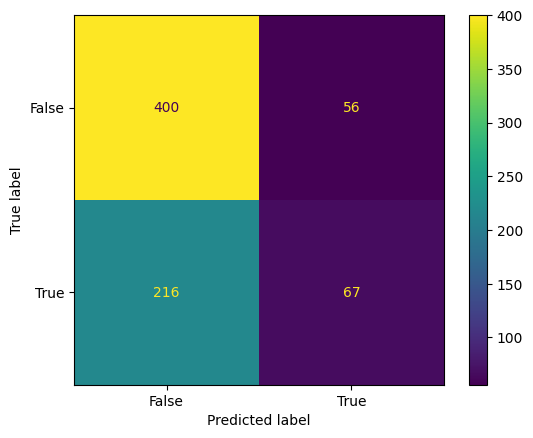

In [168]:
# RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
lr = RandomForestClassifier(n_estimators=400, random_state=42)
# fiting the model to data
lr.fit(X_train, y_train)
print(lr.score(X_train,y_train))
y_pred_lr = lr.predict(X_test)
#print(y_pred_lr)
clf_report = classification_report(y_test, y_pred_lr)
print(f"Classification Report : \n{clf_report}")
from sklearn import metrics
#calculate AUC of model
auc = metrics.roc_auc_score(y_test, y_pred_lr)
#print AUC score
print('Area Under the Curve',auc)
#printing the confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_lr)
print(f"Confusion Matrix : \n{confusion_matrix}")
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

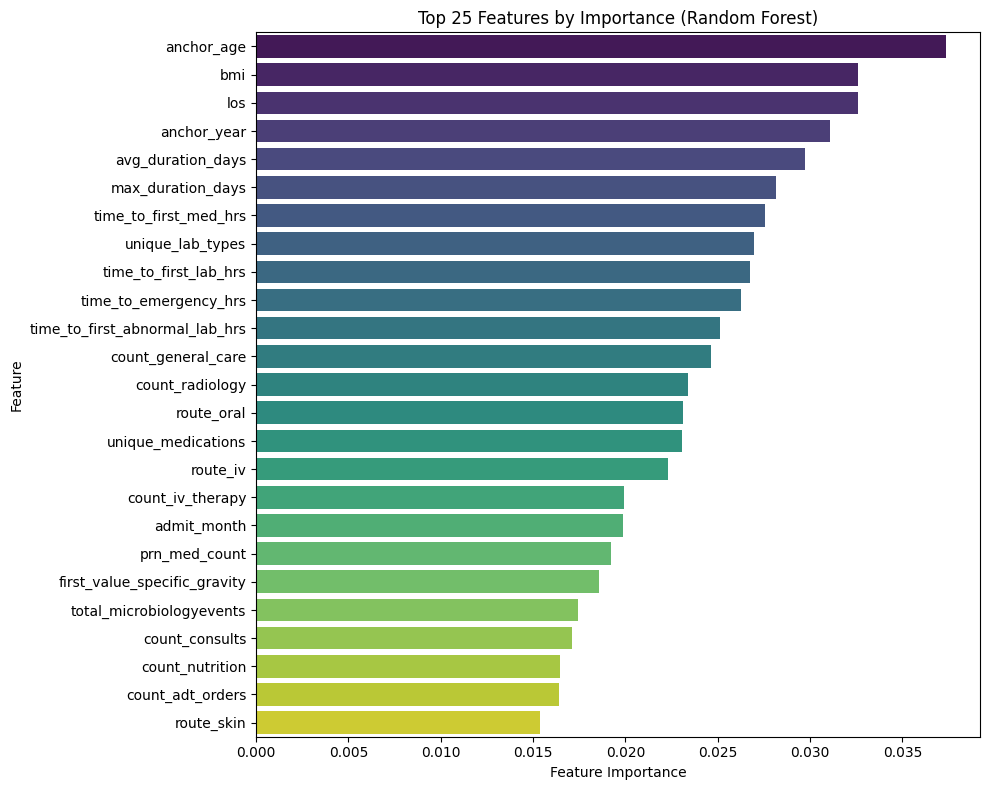

In [169]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Get feature importances
feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': lr.feature_importances_
})

# Sort by importance descending and take top 25
top_features = feature_importances.sort_values(by='importance', ascending=False).head(25)

# Plot horizontal bar chart
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=top_features, palette='viridis')
plt.title('Top 25 Features by Importance (Random Forest)')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()
